# RF Heating and current drive dimensioning

Here we explore the fabulous world of RF heating and current drive. Mostly, we try to analyse and visualize in a simple manner the dispersion relation of a magnetized cold plasma. 

In [22]:
%matplotlib inline
import sys
sys.path.append("../../PlasmaPy")
import plasmapy as pp
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

import astropy.units as u
from plasmapy.physics.parameters import gyrofrequency, plasma_frequency
from plasmapy.physics.dielectric import cold_plasma_permittivity_SDP

In [23]:
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

# Tokamak Profiles
As we will only use Cold Plasma approximation, only density and magnetic field profiles are necessary. 

In [24]:
# ITER Values
deuxpi = 2*np.pi
# Radial direction
a = 2 # m
R0 = 6.2 # m
R = np.linspace(R0-a, R0+a, num=501)

# Magnetic field
B0 = 5.3 * u.T
B = B0 * R0/R

n0 = 1.5e20
n_e0 = n0 * u.m**-3
n_i0 = n0/2 * u.m**-3

n_e = n_e0*(1 - (R-R0)**2 / a**2)
n_i = n_i0*(1 - (R-R0)**2 / a**2)

Text(0.5, 0, 'R [m]')

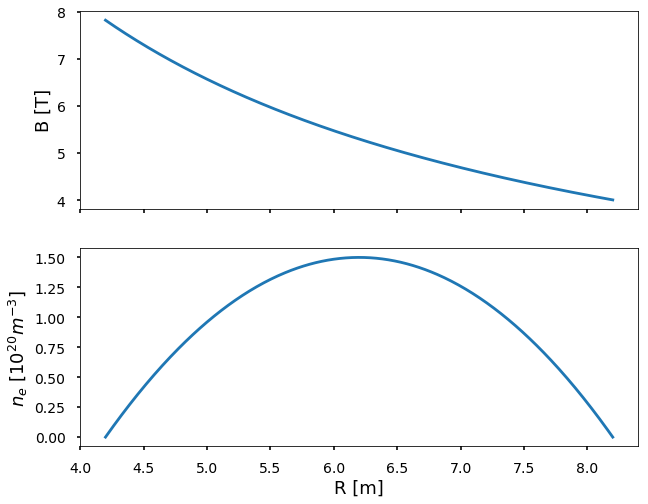

In [25]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(R, B)
ax1.set_ylabel('B [T]')
ax2.plot(R, n_e/1e20)
ax2.set_ylabel('$n_e$ [$10^{20} m^{-3}$]')
ax2.set_xlabel('R [m]')

# Cyclotron and Plasma Frequencies
In order to get an order of magnitude of the frequencies involved, we first represent the cyclotron frequencies vs tokamak parameters.

In [26]:
# gyro and plasma frequencies
omega_ce = gyrofrequency(B=B, particle='e', signed=True)
omega_ci = gyrofrequency(B=B, particle='D+', signed=True)
omega_pe = plasma_frequency(n_e, particle='e')
omega_pi = plasma_frequency(n_i, particle='D+')

The ion gyrofrequency for B=6 T is, in MHz:

In [27]:
gyrofrequency(B=6*u.T, particle='D+', signed=True)/deuxpi/1e6

<Quantity 45.75826724 rad / s>

The electron gyrofrequency for B=6 T is, in GHz :

In [28]:
gyrofrequency(B=6*u.T, particle='e')/deuxpi/1e9

<Quantity 167.95494046 rad / s>

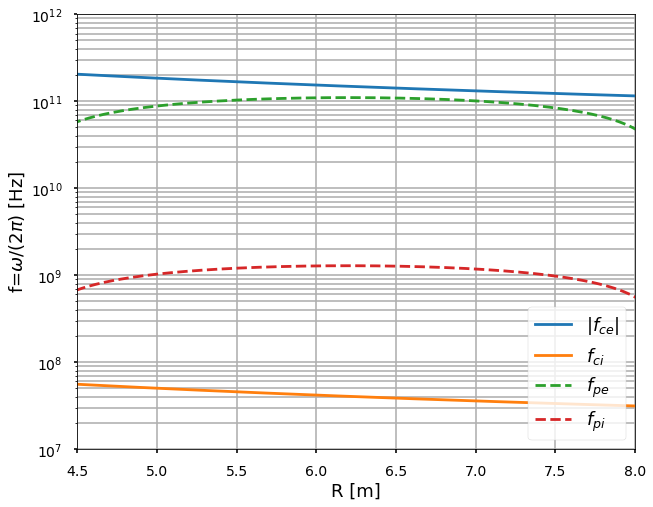

In [29]:
# plot gyro and plasma frequencies vs Radius
fig, ax = plt.subplots()
ax.semilogy(R, np.abs(omega_ce)/deuxpi, label='$|f_{ce}|$')
ax.semilogy(R, omega_ci/deuxpi, label='$f_{ci}$')
ax.semilogy(R, np.abs(omega_pe)/deuxpi, ls='--', label='$f_{pe}$')
ax.semilogy(R, omega_pi/deuxpi, ls='--', label='$f_{pi}$')

ax.legend()
ax.set_xlabel('R [m]')
ax.set_ylabel('f=$\omega/(2\pi$) [Hz]')
ax.grid(True)
ax.grid(True, which='minor', axis='both')
ax.set_xlim(4.5, 8)
ax.set_ylim(1e7, 1e12)

* Except at the edge, where a specific analysis should be made, one can see that the following ordering $\omega_{ci} << \omega_{pi} << \omega_{pe} < |\omega_ce|$ 
* Since $\omega_{ce} > \omega_{pe}$, only electrons respond to EC waves and are heated directly. 

# Cold Plasma Dielectric Tensor elements
First we plot the cold plasma dielectric tensor elements vs tokamak radii for few fixed frequencies.

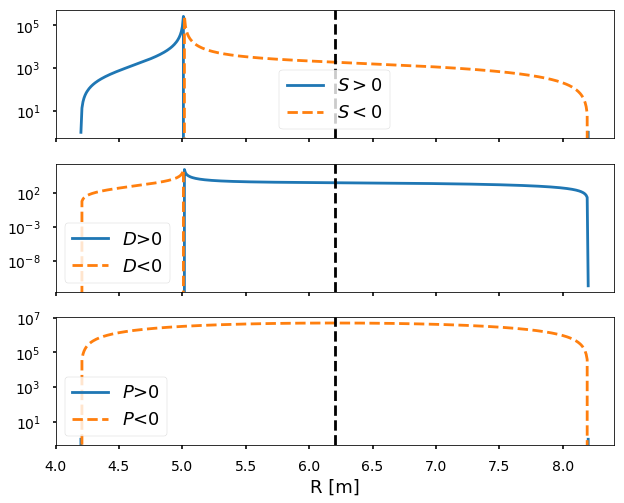

In [30]:
@interact(f = widgets.FloatLogSlider(value=50e6, base=10, min=6, max=12, step=0.01))
def plot_SDP(f):# S, D, P cold dielectric coefficients
    omega = f*deuxpi*u.rad/u.s
    S, D, P = cold_plasma_permittivity_SDP(B, species=['e', 'D+'], n=[n_e, n_i], omega=omega )

    fig, axes = plt.subplots(3, 1, sharex=True)
    axes[0].semilogy(R, (S>0)*S, label=r"$S>0$")
    axes[0].semilogy(R, (S<0)*np.abs(S), ls='--', label=r"$S<0$")
    
    axes[1].semilogy(R, (D>0)*D, label=r"$D$>0")
    axes[1].semilogy(R, (D<0)*np.abs(D), ls='--', label=r"$D$<0")
    
    axes[2].semilogy(R, (P>0)*P, label=r"$P$>0")
    axes[2].semilogy(R, (P<0)*np.abs(P), ls='--', label=r"$P$<0")
    
    [ax.axvline(R0, color='k', ls='--') for ax in axes]
    axes[-1].set_xlabel('R [m]')
    [ax.legend() for ax in axes]

From the previous figure, one can deduce the following ordering when $\omega\approx\omega_{ci}$: $|P| >> S >> D$

# Solving the Dispersion Relation


The cold plasma dispersion relation in slab approximation takes the form:
$$
    \varepsilon_\perp n_\perp^4
    -\left[(\varepsilon_\perp - n_\parallel^2)(\varepsilon_\perp + \varepsilon_\parallel) + \varepsilon_{xy}^2 \right] n_\perp^2
    + \varepsilon_\parallel\left[(\varepsilon_\perp - n_\parallel^2)^2 + \varepsilon_{xy}^2 \right]
    =
    0
$$

## ICRF
When $\omega \approx \omega_{ci}$, using the ordering found above, the dispersion relation can be approximated to:
$$
    -\left[(\varepsilon_\perp - n_\parallel^2)\varepsilon_\parallel + \varepsilon_{xy}^2 \right] n_\perp^2
    + \varepsilon_\parallel\left[(\varepsilon_\perp - n_\parallel^2)^2 + \varepsilon_{xy}^2 \right]
    =
    0
$$
which solution is:
$$
n_\perp^2 
\approx
\frac{(\varepsilon_\perp - n_\parallel^2)^2 + \varepsilon_{xy}^2}{\varepsilon_\perp - n_\parallel^2}
=
\frac{
    (\varepsilon_\perp - n_\parallel^2) - i \varepsilon_{xy})((\varepsilon_\perp - n_\parallel^2) + i\varepsilon_{xy})
    }{\varepsilon_\perp - n_\parallel^2}
$$

So two cut-off may appear for 

$$
\varepsilon_\perp \pm \varepsilon_{xy} = n_\parallel^2
$$
while a resonance appear for
$$
\varepsilon_\perp = n_\parallel^2
$$
the hybrid resonance

## ECRF
The cold plasma dispersion relation can be approximated to ($n_\parallel=0$):
$$
    \varepsilon_\perp n_\perp^4
    -\left[ \varepsilon_\perp^2 + \varepsilon_{xy}^2 \right] n_\perp^2
    + \varepsilon_\parallel \left[ \varepsilon_\perp^2 + \varepsilon_{xy}^2 \right]
    =
    0
$$

In [31]:
def disp_rel_coeffs(S, P, D, omega, n_parallel):
    A4 = S
    A2 = -((S - n_parallel**2) * (S + P) + (1j*D)**2)
    A0 = P*((S - n_parallel**2)**2 + (1j*D)**2)
    return np.array([A4,  A2,  A0])


In [32]:
def n_perp_sq(f, n_parallel=1.0):
    omega = f*deuxpi*u.rad/u.s
    S, D, P = cold_plasma_permittivity_SDP(B, species=['e', 'D+'], n=[n_e, n_i], omega=omega )
    ps = disp_rel_coeffs(S, P, D, omega, n_parallel)

    n_perp_squared = []
    for p in ps.T:
        n_perp_squared.append(np.roots(p))

    return np.array(n_perp_squared)

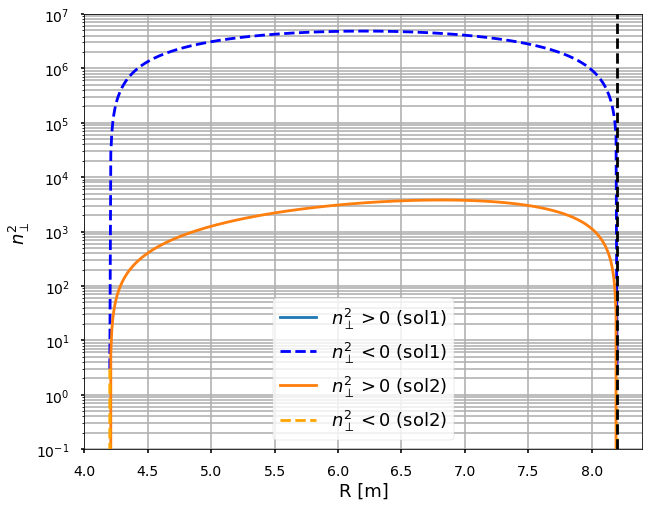

In [43]:
@interact(f = widgets.FloatLogSlider(value=50e6, base=10, min=6, max=12, step=0.01), 
         n_parallel = widgets.FloatSlider(value=2, min=0, max=50, step=0.1))
def plot_n_perp_squared(f, n_parallel):
    n_perp_squared = n_perp_sq(f, n_parallel)
    
    omega = f*deuxpi*u.rad/u.s
    
    fig, ax = plt.subplots()
    # analytical solution
    
    ax.semilogy(R, (n_perp_squared[:,0] > 0) * n_perp_squared[:,0] , label='$n_\perp^2 > 0$ (sol1)')
    ax.semilogy(R, (n_perp_squared[:,0] < 0) * np.abs(n_perp_squared[:,0]), ls='--', color='b', label='$n_\perp^2 < 0$ (sol1)')

    ax.semilogy(R, (n_perp_squared[:,1] > 0) * n_perp_squared[:,1] , label='$n_\perp^2 > 0$ (sol2)')
    ax.semilogy(R, (n_perp_squared[:,1] < 0) * np.abs(n_perp_squared[:,1]), ls='--', color='orange', label='$n_\perp^2 < 0$ (sol2)')

    #S, D, P = cold_plasma_permittivity_SDP(B, species=['e', 'D+'], n=[n_e, n_i], omega=omega )
    #n_a = ((S-n_parallel**2)**2 + (1j*D)**2)/(S - n_parallel**2)
    #ax.semilogy(R, (n_a>0)*n_a, color='r', label=r'approx $\omega\approx\omega_{ci} > 0$')
    #ax.semilogy(R, (n_a<0)*np.abs(n_a), ls='--', color='r', label=r'approx $\omega\approx\omega_{ci} < 0$')
    
    
    ax.grid(True)
    ax.grid(True, which='both', axis='both')
    ax.set_xlabel('R [m]')
    ax.set_ylabel('$n_\perp^2$')
    ax.legend()
    ax.set_ylim(bottom=1e-1)
    ax.axvline(R0+a, color='k', ls='--')

Few observations:

* the wave with the lowest $n_\perp^2$ is called the 'fast-wave', as its phase velocity is higher ($v_\phi = c/n_\perp$)

* note that the slow wave is evanesnt in vacuum ($n_\parallel < 1$) for LHRF

* Remark that for ICRF range of frequency, $n_\perp^2$ is not positive at $R=R_0+a$ but for a value which is below. Cut-off density : value at which $n_\perp^2=0$
* existence of a density limit for EC but not for IC

Below we illustrate the $n_\perp^2$ for the X-mode on the ECRH range of frequencies

Text(0, 0.5, '$n_\\perp^2$')

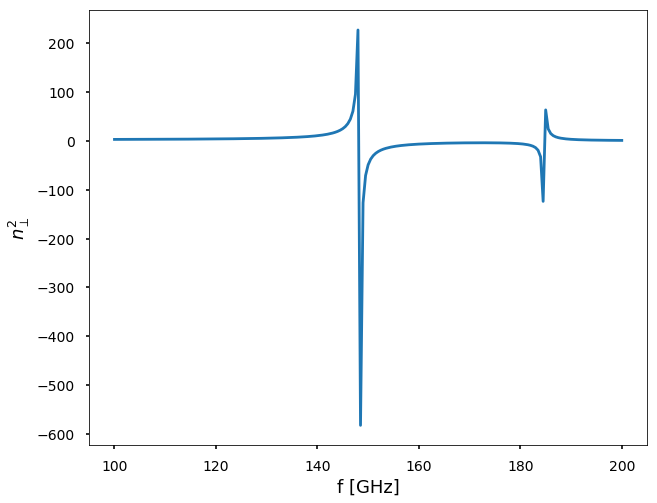

In [42]:
f = np.linspace(100e9, 200e9, num=201)
omega = f*deuxpi*u.rad/u.s
n0 = 1.5e20 * u.m**-3
    
S, D, P = cold_plasma_permittivity_SDP(B=5.3*u.T, species=['e', 'D+'], n=[n0, n0/2], omega=omega)
n_perp_square_X = (S**2 - (1j*D)**2)/S

fig, ax = plt.subplots()
ax.plot(f/1e9, n_perp_square_X)
ax.set_xlabel('f [GHz]')   
ax.set_ylabel('$n_\perp^2$')

Best frequencies are around 40 MHz and 140 GHz for ion and electron cyclotron heating in Iter. Does it match with the selected ones? What constraints on scenarios?

# ICRH
Cyclotron damping occurs when the wave electric field has component perpendicular to $\bf B_0$

## Polarization

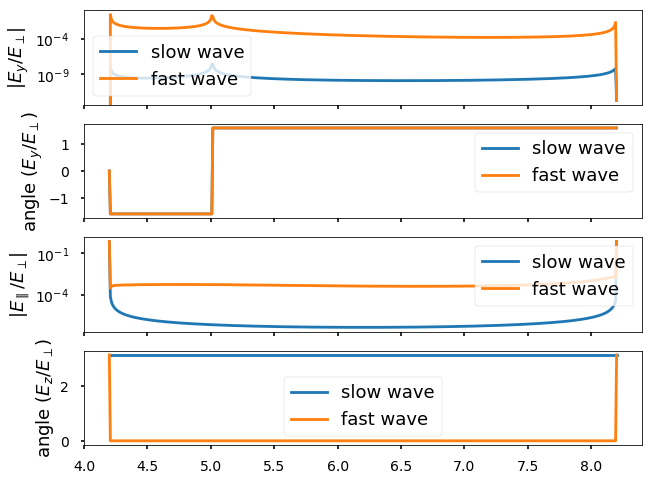

In [35]:
@interact(f = widgets.FloatLogSlider(value=50e6, base=10, min=6, max=12, step=0.01), 
         n_parallel = widgets.FloatSlider(value=2, min=0, max=50, step=0.1))
def plot_ratioE_squared(f, n_parallel):
    n_perp_squared = n_perp_sq(f, n_parallel)
    
    omega = f*deuxpi*u.rad/u.s
    S, D, P = cold_plasma_permittivity_SDP(B, species=['e', 'D+'], n=[n_e, n_i], omega=omega )
    
    #Ey_over_Ex = -S/(1j*D)
    #Ez_over_Ex_1 = -np.sqrt(n_perp_squared[:,0])*n_parallel / (P - n_perp_squared[:,0])
    #Ez_over_Ex_2 = -np.sqrt(n_perp_squared[:,1])*n_parallel / (P - n_perp_squared[:,1])
    Ey_over_Ex1 = 1j*D/(n_perp_squared[:,0]**2 + n_parallel**2 - S)
    Ey_over_Ex2 = 1j*D/(n_perp_squared[:,1]**2 + n_parallel**2 - S)
    
    Ez_over_Ex1 = n_perp_squared[:,0]*n_parallel / (n_perp_squared[:,0]**2 - P)
    Ez_over_Ex2 = n_perp_squared[:,1]*n_parallel / (n_perp_squared[:,1]**2 - P)
    
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].semilogy(R, np.abs(Ey_over_Ex1), label='slow wave')
    ax[0].semilogy(R, np.abs(Ey_over_Ex2), label='fast wave')
    ax[0].legend()
    ax[0].set_ylabel('$|E_y/E_\perp|$')
    
    ax[1].plot(R, np.angle(Ey_over_Ex1), label='slow wave')
    ax[1].plot(R, np.angle(Ey_over_Ex2), label='fast wave')
    ax[1].legend()
    ax[1].set_ylabel('angle $(E_y/E_\perp)$')
    
    ax[2].semilogy(R, np.abs(Ez_over_Ex1), label='slow wave')
    ax[2].semilogy(R, np.abs(Ez_over_Ex2), label='fast wave')
    ax[2].set_ylabel('$|E_\parallel/E_\perp|$')
    ax[2].legend()
    
    ax[3].plot(R, np.angle(Ez_over_Ex1), label='slow wave')
    ax[3].plot(R, np.angle(Ez_over_Ex2), label='fast wave')
    ax[3].legend()
    ax[3].set_ylabel('angle $(E_z/E_\perp)$')
    

# Analytical treatment
This is a try on SymPy for doing calculus job

In [36]:
from sympy import *
from scipy.constants import mu_0, e, m_e, m_p
init_printing()

In [37]:
omega_pe, omega_pi = symbols('omega_pe omega_pi')
omega_ce, omega_ci = symbols('omega_ce omega_ci')
n_parallel, n_perp = symbols('n_parallel n_perp')
omega, x = symbols('omega, x')

In [38]:
epsilon_perp =  - omega_pe**2 / (omega**2 - omega_ce**2) - omega_pi**2 / (omega**2 - omega_ci**2)
epsilon_parallel = 1 - omega_pe**2 / omega**2 - omega_pi**2/omega**2
epsilon_xy = 1j * omega_pe**2 * omega_ce / (omega * (omega_ce**2 - omega**2)) + 1j * omega_pi**2 * omega_ci / (omega * (omega_ci**2 - omega**2))

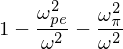

In [39]:
epsilon_parallel

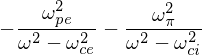

In [40]:
epsilon_perp

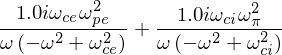

In [41]:
epsilon_xy

## Ion Cyclotron frequency range
The ICRF frequency range is defined by $\omega \approx \omega_{ci}$ and $\omega << \omega_{ce}$